In [1]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.utils import to_categorical


In [2]:
#load dataset
# Ganti path sesuai lokasi file Anda di Google Colab
df = pd.read_csv('ReviewTokoBaju (1).csv')

df.head()


,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [11]:
#preprocessing data
# Cek kolom
print(df.columns)

# Misal kolom review dan labelnya bernama 'Review' dan 'Label'
text_col = 'Review Text'   # ganti sesuai nama kolom sebenarnya
label_col = 'Recommended IND'   # ganti sesuai nama kolom sebenarnya

# Check the actual column names in df to ensure 'Sentiment' exists or
# update label_col to the correct column name if it's different.
# print(df.columns) # Uncomment this line to see the actual column names

# --- Start of suggested changes ---
# Identify classes with only one member
class_counts = df[label_col].value_counts()
classes_to_remove = class_counts[class_counts < 2].index

# Remove rows where the label is in the list of classes to remove
df_filtered = df[~df[label_col].isin(classes_to_remove)].copy() # Create a copy to avoid SettingWithCopyWarning

# Check the size of the filtered dataframe
print(f"Original dataframe size: {len(df)}")
print(f"Filtered dataframe size: {len(df_filtered)}")
# --- End of suggested changes ---


# Encode label - use the filtered dataframe
le = LabelEncoder()
df_filtered[label_col] = le.fit_transform(df_filtered[label_col])

# Split dataset - use the filtered dataframe
X_train, X_test, y_train, y_test = train_test_split(
    df_filtered[text_col], df_filtered[label_col], test_size=0.2, random_state=42, stratify=df_filtered[label_col] # Stratify using the filtered data
)

Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')
Original dataframe size: 23486
Filtered dataframe size: 23486


In [13]:
# Convert any non-string values in X_train to string and fill potential NaN with empty string
X_train = X_train.astype(str).fillna('')
# Convert any non-string values in X_test to string and fill potential NaN with empty string
X_test = X_test.astype(str).fillna('')

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

In [14]:
#model RNN
model = Sequential([
    Embedding(input_dim=max_words, output_dim=64, input_length=max_len),
    SimpleRNN(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:
#Train
history = model.fit(X_train_pad, y_train, epochs=10, batch_size=32,
                    validation_data=(X_test_pad, y_test))


Epoch 1/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.8173 - loss: 0.4856 - val_accuracy: 0.8223 - val_loss: 0.4690
Epoch 2/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.8139 - loss: 0.4874 - val_accuracy: 0.8223 - val_loss: 0.4690
Epoch 3/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.8217 - loss: 0.4621 - val_accuracy: 0.8223 - val_loss: 0.4755
Epoch 4/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.8300 - loss: 0.4411 - val_accuracy: 0.8125 - val_loss: 0.4855
Epoch 5/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - accuracy: 0.8518 - loss: 0.4029 - val_accuracy: 0.8095 - val_loss: 0.4936
Epoch 6/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - accuracy: 0.8541 - loss: 0.3936 - val_accuracy: 0.7888 - val_loss: 0.5327
Epoch 7/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - accuracy: 0.8680 - loss: 0.3639 - val_accuracy: 0.7961 - val_loss: 0.5499
Epoch 8/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.8642 - loss: 0.3652 - 

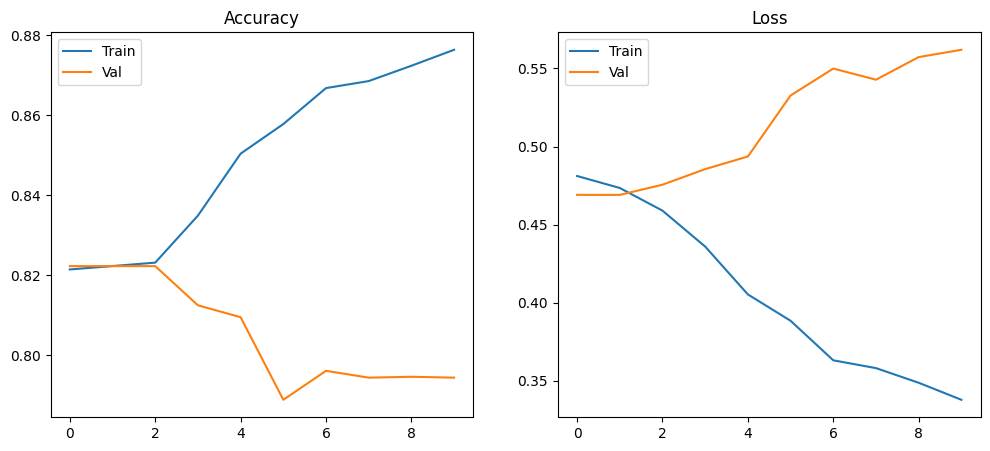

In [16]:
#visualisasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("Loss")
plt.legend()

plt.show()


147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Accuracy: 0.7943805874840357
Precision: 0.8274926520461225
Recall: 0.947450168263008
F1 Score: 0.8834178131788559
AUC-ROC: 0.5256172097947516


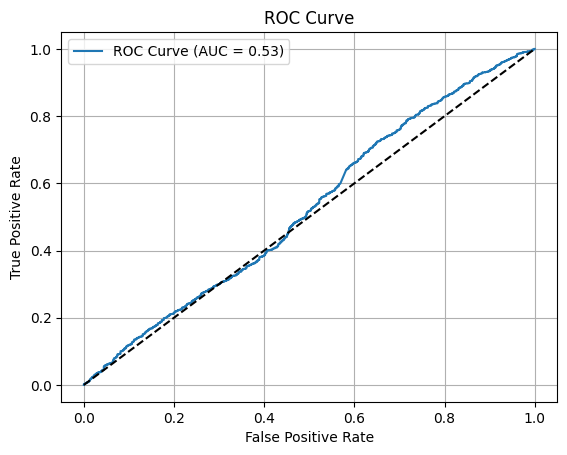

In [17]:
#evaluasi model
y_pred_prob = model.predict(X_test_pad).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_prob))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_score(y_test, y_pred_prob)))
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')
plt.grid()
plt.show()


**Berikut penjelasan persamaan penting:**

* **Binary Crossentropy Loss:**

  $$
  \mathcal{L} = -\frac{1}{N} \sum_{i=1}^{N} [y_i \log(\hat{y}_i) + (1 - y_i)\log(1 - \hat{y}_i)]
  $$

  → Mengukur seberapa baik prediksi $\hat{y}_i$ terhadap label asli $y_i$.

* **Akurasi:**

  $$
  \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
  $$

* **Presisi:**

  $$
  \text{Precision} = \frac{TP}{TP + FP}
  $$

* **Recall:**

  $$
  \text{Recall} = \frac{TP}{TP + FN}
  $$

* **F1-Score:**

  $$
  F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
  $$

* **AUC-ROC** adalah area di bawah kurva ROC: representasi trade-off antara TPR dan FPR.


**Accuracy & Loss**

* **Train Accuracy**: naik sampai \~88%

* **Val Accuracy**: turun jadi \~79%
  ➡ Terjadi **overfitting** → model belajar terlalu baik di training set, tapi gagal generalisasi ke validation/test set.

* **Train Loss**: turun stabil


**Precision, Recall, F1**

* **Precision**: 82.7% → cukup oke, model lumayan tepat prediksi positif.
* **Recall**: 94.7% → model berhasil menangkap hampir semua yang positif.
* **F1 Score**: 88.3% → balance bagus antara precision & recall.

**AUC-ROC**
* **AUC: 0.53** → hanya sedikit di atas random (0.5).
  ROC curve juga dekat garis diagonal → model tidak mampu memisahkan positif & negatif secara confident.


